### Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy
import re

from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from collections import Counter
from typing import List

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
sns.set_style("whitegrid")

### Read data

In [2]:
df = pd.read_csv("../data/products.csv")

### Preprocessings

A pattern I've been considering is to remove elements with a value count higher than one since I don't need a list with duplicate products. Additionally, as you just noticed, the inclusion of 'non-products' could potentially lead to repetitive entries.

In [3]:
# Calculate value counts for the 'product_name' column
value_counts = df['product_name'].value_counts()

# Filter the products list to keep only rows with count equal to 1
df_unique_products = df[df['product_name'].map(value_counts) == 1][['product_name', 'url']].reset_index(drop=True)

# Convert the 'product_name' series to a list for the text cleaning process
products = df_unique_products['product_name'].to_list()
products = [i for i in products if len(i) > 0]

#### Text Cleaning

Remove unnecessary characters

In [4]:
def clean_text(products: List[str]) -> List[str]:
    cleaned_products = []
    for product in products:
        # Remove URLs
        product = re.sub(r'http\S+|www.\S+', '', product)
        # Remove HTML tags
        product = re.sub(r'<.*?>', '', product)
        # Convert to lower case
        product = product.lower()
        # Remove numbers, currencies, punctuation and any other non-alphabet characters
        product = re.sub('[^a-z\s]', '', product)
        product = re.sub('\d+', 's', product)
        # Replace new line characters and consecutive whitespaces with a single space
        product = re.sub('\s+', ' ', product)
        cleaned_products.append(product)
    return cleaned_products

In [5]:
products = clean_text(products)

#### Removal of Stopwords

In [6]:
# I've tried to remove the words with nltk first, but I've noticed that spacy has a broader list of stop words
# With nltk I removed 788 stop words, but with spacey I managed to remove 100 more, 888
stop_words = nlp.Defaults.stop_words

def remove_stopwords(products: List[str], stop_words: set) -> (List[str], List[str]):
    stopwords = []
    filtered_products = []
    for product in products:
        words = product.split()
        filtered_product = []
        for word in words:
            if word in stop_words:
                stopwords.append(word)
            else:
                filtered_product.append(word)
        filtered_products.append(' '.join(filtered_product))
    return filtered_products, stopwords

In [7]:
filtered_products, stopwords = remove_stopwords(products, stop_words)

Let's display a WordCloud with the removed stop words

In [8]:
stopwords_frequencies = Counter(stopwords)

# Calculate total number of words
total_stop_words = len(stopwords)

# Calculate percentages and store in a dictionary
stopword_percentages = {word: (frequency / total_stop_words) * 100 for word, frequency in stopwords_frequencies.items()}

In [9]:
print(f"A total of {total_stop_words} stop words were removed.")

A total of 282 stop words were removed.


Visualize WordCloud

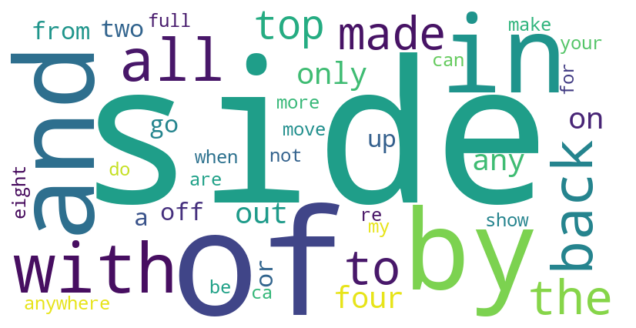

In [10]:
stopwords_wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(stopword_percentages)

plt.figure(figsize=(8, 4))
plt.imshow(stopwords_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### Lemmatization

In [11]:
lemmatized_products = []

for product in filtered_products:
    doc = nlp(product)
    # Extract the lemma for each token and join
    lemmatized_product = ' '.join([token.lemma_ for token in doc])
    lemmatized_products.append(lemmatized_product)

#### Create another Word Cloud to see the most popular products

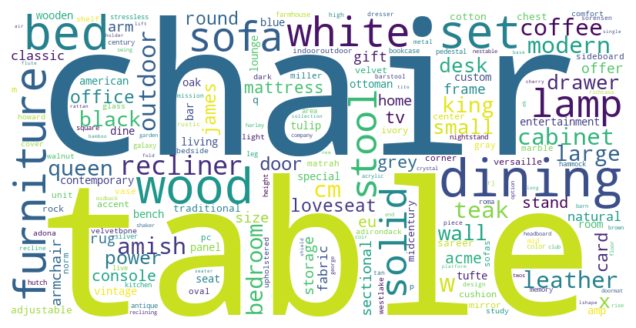

In [12]:
# Combine all the words from the dataframe into a single list
all_words = [word for extraction in lemmatized_products for word in extraction.split()]

# Calculate word frequencies
word_frequencies = Counter(all_words)

# Generate the word cloud
wordcloud = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_frequencies)

# Plot the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Export the dataframe

In [13]:
df_products = pd.DataFrame({'Products': [sentence for sentence in products]})
df_products['url'] = df_unique_products['url'].values

# Export it
df_products.to_csv('../data/products_dataset.csv', index=False)